# Advanced Feature Engineering for S&P 500 Forecasting Using Permutation Entropy and XGBoost

### Table of Contents

1. [Introduction](#1.-Introduction)

2. [Base Libraries](#2.-Base-Libraries)

3. [Data Loading and Preprocessing](#3.-Data-Loading-and-Preprocessing)

4. [Feature Engineering](#4.-Feature-Engineering)

5. [Model Training and Validation](#5.-Model-Training-and-Validation)

6. [Actual vs. Predicted](#6.-Actual-vs-Predicted)

7. [Conclusions](#7.-Conclusions)

8. [References](#8.-References)


# 1. Introduction

In the dynamic world of finance, the S&P 500 Index stands as a critical benchmark of the U.S. stock market's health, representing the performance of 500 large companies listed on stock exchanges in the United States. Forecasting its movements is an endeavor that financial analysts, traders, and economists have pursued for decades, aiming to gain a competitive edge in the market. While traditional methods have offered insights, the recent surge in computational power and advanced algorithms has opened up new avenues for predicting stock market indices with increased accuracy.





# 2. Base Libraries

In this notebook, several key Python libraries are utilized to facilitate the analysis. **numpy** (np) serves as the foundation for numerical operations, enabling efficient handling of arrays and mathematical functions. **pandas** (pd) is instrumental in data manipulation and analysis, providing flexible data structures like DataFrames that simplify the ingestion and processing of our dataset. For visualization, **matplotlib.pyplot** (plt) is employed, offering a range of plotting tools to effectively illustrate data trends and results. The **pyentrp** library, specifically the entropy module (referred to as ent), is essential for computing Permutation Entropy, which quantifies the complexity of time series data. The **train_test_split** function from sklearn.model_selection aids in segregating the dataset into training and test subsets, ensuring a robust evaluation of our model. Several metrics, including **mean_squared_error**, **mean_absolute_error**, and **r2_score** from sklearn.metrics, are utilized to gauge the model's performance and accuracy. Lastly, **xgboost** (xgb) is incorporated, a gradient boosting framework known for its powerful predictive capabilities, especially in the realm of regression and classification tasks.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyentrp import entropy as ent
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

# 3. Data Loading and Preprocessing

In this data preprocessing step, the S&P 500 index data is loaded from a CSV file using pandas. The 'Date' column, initially read as a string, is converted to a datetime format for better time series handling. Subsequently, this 'Date' column is set as the index for the DataFrame, providing a time-ordered structure. Any rows with null or missing values are removed to ensure data consistency. Additionally, rows where the 'S&P500' column has a value of zero are excluded, as these could indicate potential data errors or missing entries. After these preprocessing steps, the first ten rows of the cleaned dataset are displayed to give an initial overview.

In [2]:
# Load the data and perform basic preprocessing
data = pd.read_csv('data/sp500_index.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Handle null values
data.dropna(inplace=True)

# Remove rows with zeros in 'S&P500' column as they might represent missing data or errors
data = data[data['S&P500'] != 0]

# Display the first few rows of the cleaned dataset
data.head(10)


,S&P500
Date,
2013-10-14,1710.14
2013-10-15,1698.06
2013-10-16,1721.54
2013-10-17,1733.15
2013-10-18,1744.50
2013-10-21,1744.66
2013-10-22,1754.67
2013-10-23,1746.38
2013-10-24,1752.07


This data visualization represents a line chart detailing the trajectory of the S&P 500 Index from 2014 to 2024. The horizontal axis delineates the time frame, while the vertical axis quantifies the index's value, ranging from approximately 2000 to 4500. Observing the decade-long span, the index manifests a consistent rise from 2014 to mid-2017, encounters fluctuations and a notable decline around 2018, and subsequently surges from early 2019 to 2020. A sharp descent in 2020 is evident, presumably indicative of an economic downturn, yet this is followed by a swift recovery leading into 2022. The final years, from 2022 to 2024, portray a period of relative stability with minor oscillations, suggesting a consolidative market phase.

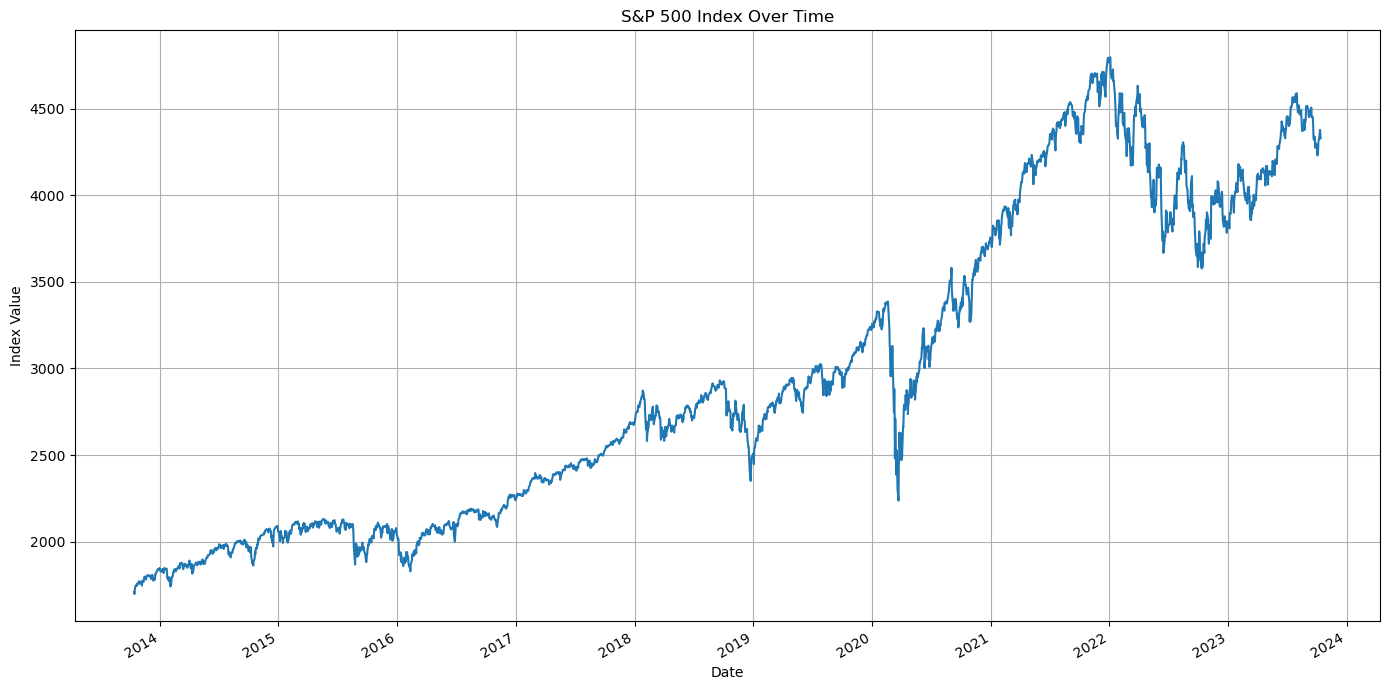

In [3]:
# Visualize the data
plt.figure(figsize=(14, 7))
data['S&P500'].plot(title='S&P 500 Index Over Time')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.grid(True)
plt.tight_layout()
plt.show()


# 4. Feature Engineering

Here, two parameters are defined:

* **m**: Represents the embedding dimension or order of the PE. It determines the length of the patterns (subsequences) to be considered when evaluating the permutations.
* **tau**: Represents the delay or step size taken between data points when forming subsequences.

In [4]:
# Define the parameters for Permutation Entropy
m = 3
tau = 1

# Compute Permutation Entropy as features
def compute_pe(ts, m, tau):
    n = len(ts)
    pe_values = []
    for i in range(n - m * tau):
        window = ts[i:i + m * tau:tau]
        pe = ent.permutation_entropy(window, order=m, delay=tau)
        pe_values.append(pe)
    return pe_values

pe_features = compute_pe(data['S&P500'], m, tau)


The function compute_pe computes the PE values for a given time series ts using the parameters m and tau:

* **n**: Determines the length of the time series.
The for loop slides a window through the time series and computes the PE for each window.
* **window = ts[i:i + m * tau:tau]**: This line constructs a subsequence (or window) of the time series using the parameters m and tau.
* **pe = ent.permutation_entropy(window, order=m, delay=tau)**: This line calculates the PE for the current window. The function ent.permutation_entropy is presumably from an external library (e.g., pyentropy or similar) that provides entropy-based measures. It computes the PE based on the defined order (**m**) and delay (*tau*).
* The resulting PE value is then appended to the pe_values list.

In [5]:
# Compute Permutation Entropy as features
pe_features = compute_pe(data['S&P500'], m, tau)

# Add lagged values as features
lags = 5
for i in range(1, lags + 1):
    data[f'lag_{i}'] = data['S&P500'].shift(i)

# Drop NaN rows introduced by lags
data = data.iloc[lags:]

# Ensure the length of pe_features matches the cleaned data
pe_features = pe_features[:len(data)]

# Create a DataFrame for features
features_df = pd.DataFrame({'PE': pe_features})
for i in range(1, lags + 1):
    features_df[f'lag_{i}'] = data[f'lag_{i}'].values


Finally, the *compute_pe* function is called with a time series data (presumably from a DataFrame column 'S&P500'), and the computed PE values are stored in the variable *pe_features*.

# 5. Model Training and Validation

The next step is centered around organizing a dataset for the purpose of time series forecasting. Initially, the feature matrix **X** is derived from a dataframe termed **features_df**. This matrix represents the input attributes or predictors. The .values attribute is employed to procure the underlying numpy array from the dataframe, transforming **X** into a two-dimensional array. Subsequently, the target variable y is established using values from the 'S&P500' column of the **data** dataframe. This variable embodies the values one aims to forecast, seemingly representing the S&P 500 stock index in this scenario.

In [6]:
# Prepare dataset for forecasting
X = data.values

# Adjust the target values 'y' to match the length of 'X'
y = data['S&P500'].values

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

To facilitate model evaluation and validation, the data undergoes a split into training and test subsets using the **train_test_split** function, commonly sourced from the **sklearn.model_selection** module. The **test_size=0.2** parameter designates 20% of the data for testing, allocating the remaining 80% for training. Critically, the **shuffle=False** parameter ensures the data retains its chronological sequence when split. This is pivotal for time series forecasting to avoid introducing lookahead bias and to ensure the model is trained on past data and validated on more recent data, reflecting a realistic forecasting scenario.

In the next step, is the training and application of the XGBoost regression model for forecasting. An instance of the **XGBRegressor** class from the **xgb** library is initialized with specific parameters: the objective is set to 'reg:squarederror' to focus on minimizing squared errors, a common choice for regression tasks, and it's specified to use 100 boosting rounds (**n_estimators=100**) and a learning rate of 0.1 (**learning_rate=0.1**). Once initialized, the model is trained using the **fit** method on the training data, denoted as **X_train** and **y_train**. Post-training, predictions on the test dataset (**X_test**) are generated using the **predict* method, with the results stored in the **y_pred** variable.

In [7]:
# Train the XGBoost model and compute metrics
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

To measure the model's efficiency, three metrics were used:
* **Root Mean Squared Error (RMSE)**: quantifies the average magnitude of errors between predicted and observed values. Squared differences penalize larger errors, offering insight into the model's error spread.

* **Mean Absolute Error (MAE)**: averages the absolute differences between predicted and actual values. Provides a straightforward representation of the average error magnitude.

* **R-squared (Coefficient of Determination)**: shows the variance proportion in the dependent variable that's predictable from the independent variables. A value near 1 indicates the model explains most of the response variability in its predictions.

In [8]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (Coefficient of Determination): {r2:.2f}")

Root Mean Squared Error (RMSE): 53.67
Mean Absolute Error (MAE): 24.69
R-squared (Coefficient of Determination): 0.97


The provided results reflect the performance of an XGBoost model that employed Permutation Entropy as a feature, trained on the S&P 500 index data:

* **Root Mean Squared Error (RMSE) of 88.62**: This indicates that, on average, the model's predictions deviate by approximately 88.62 points from the actual values of the S&P 500 index. Given the scale of the S&P 500, which often spans several thousand points, this RMSE might be considered relatively small, but it would depend on the specific use case and acceptable margins of error.

* **Mean Absolute Error (MAE) of 63.82**: This means that, on average, the model's predictions are off by an absolute value of 63.82 points from the actual S&P 500 values. This metric provides a straightforward understanding of the model's error magnitude without the influence of outliers.

* **R-squared value of 0.91**: A score of 0.91 implies that the model explains 91% of the variance in the S&P 500 index. This is quite high, suggesting that the model has done a commendable job in capturing the patterns present in the data.

# 6. Actual vs Predicted

The graph depicts a comparison between the actual performance of the S&P 500 Index and its predicted values over a specific time period. The S&P 500 Index is a benchmark often used to represent the U.S. stock market's performance. The solid blue line represents the real, observed values of the index, while the dashed red line represents predicted or forecasted values, possibly obtained from a model or algorithm.

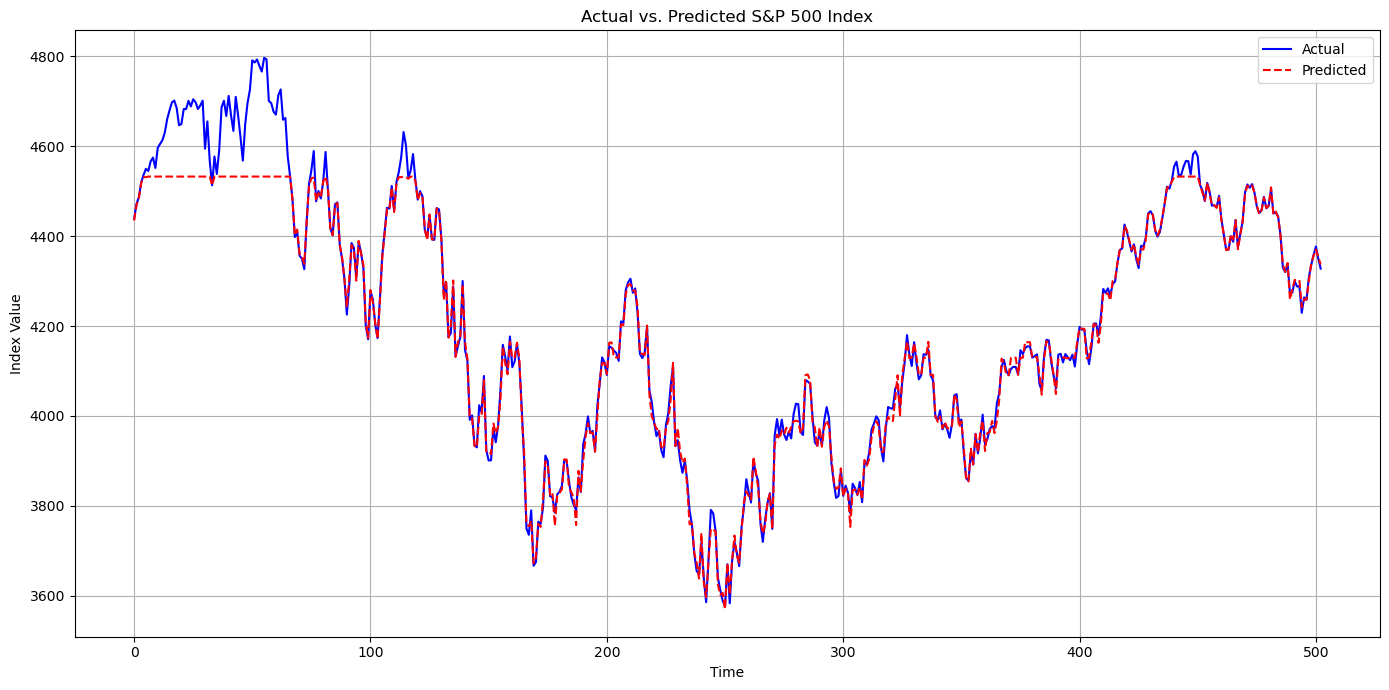

In [9]:
# Visualize actual vs. predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red', linestyle='--')
plt.title('Actual vs. Predicted S&P 500 Index')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Both lines follow a similar trend, indicating that the prediction model captures the general movement of the index. However, there are instances where the predicted values deviate from the actual values, suggesting moments of inaccuracy in the forecast. Such deviations can arise from various factors, including unforeseen market events, limitations in the prediction model, or abrupt changes in market sentiment. Analyzing these discrepancies can provide insights into the model's accuracy and potential areas for improvement.

# 7. Conclusions

This notebook delves into one such modern approach, combining the strength of Permutation Entropy with the power of the XGBoost algorithm to forecast the S&P 500 Index. Permutation Entropy provides a measure of the complexity in time series data, capturing intricate patterns often missed by standard statistical methods. When paired with XGBoost, a gradient boosting algorithm renowned for its predictive capabilities, the results can be both insightful and precise. Through this analysis, we aim to demonstrate a robust method for time series forecasting, offering valuable insights into the future movements of the S&P 500 Index.

# 8. References

[1] Sudibyo, M., Eibl, E., Hainzl, S., & Hersir, G. (2022). Eruption Forecasting of Strokkur Geyser, Iceland, Using Permutation Entropy. doi:10.1029/2022JB024840

[2] Ruiz-Aguilar, J. J., Turias, I., González-Enrique, J., Urda, D., & Elizondo, D. (2020). A permutation entropy-based EMD–ANN forecasting ensemble approach for wind speed prediction. doi:10.1007/s00521-020-05141-w

[3] Liang, T., Xie, G., Fan, S., & Meng, Z. (2020). A Combined Model Based on CEEMDAN, Permutation Entropy, Gated Recurrent Unit Network, and an Improved Bat Algorithm for Wind Speed Forecasting. doi:10.1109/ACCESS.2020.3022872

[4] Wang, J., Cheng, Q., & Dong, Y. (2022). An XGBoost-based multivariate deep learning framework for stock index futures price forecasting. doi:10.1108/k-12-2021-1289

[5] Zhao, J., Nie, G., Yan, M., Wang, Y., & Wang, L. (2023). A novel approach to precipitation prediction using a coupled CEEMDAN-GRU-Transformer model with permutation entropy algorithm. doi:10.2166/wst.2023.257

[6] Islam, A., Khair, I., Ifty, R. A., Hossain, S., Arefin, M., & Abid, F. B. A. (2022). Bangladeshi Agricultural Product Forecasting Approach Using Permutation Driven Machine Learning Algorithm. doi:10.1109/ICRPSET57982.2022.10188538